### Installing dependencies for preprocessing of images 

In [1]:
!pip install imutils
import numpy as np 
import pandas as pd 
import os
import itertools
from os import listdir
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    
import zipfile
import os


### Adding the necessary functions and importing the required packages

Importing models and functions from keras and tensorflow

In [2]:
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.utils import shuffle
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import  RMSprop


Importing the dataset

In [3]:
!rm -rf capstone
!git clone https://github.com/suhas9897/capstone.git 

Cloning into 'capstone'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


Unzipping the dataset file cloned from Github

In [4]:
zip_ref = zipfile.ZipFile('/content/capstone/archive (6).zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/capstone') #Extracts the files into the /tmp folder
zip_ref.close()

## Data Preprocessing : Augmentation of images 

Since there are only few images in the dataset,data augmentation is done 

In [5]:
def augment_data(dir_file, sample_count, save_to_dir):
    generator = ImageDataGenerator(rotation_range=12, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest',
                                  preprocessing_function=preprocess_input
                                 )

    for filename in listdir(dir_file):
        image = cv2.imread(dir_file + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in generator.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > sample_count:
                    break

### Making directory for augmented images

In [6]:
image_dir= '/content/capstone/brain_tumor_dataset/'
!rm -rf '../content/capstone/a_images'
os.makedirs('../content/capstone/a_images')
os.makedirs('../content/capstone/a_images/yes')
os.makedirs('../content/capstone/a_images/no')

In [7]:
augmented_data_path ='/content/capstone/a_images/'
augment_data(dir_file=image_dir+'yes',sample_count=6, save_to_dir=augmented_data_path+'yes')
augment_data(dir_file=image_dir+'no',sample_count=8, save_to_dir=augmented_data_path+'no')

## Data Preprocessing : Cropping Images

In [8]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    threshold_val = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_val = cv2.erode(threshold_val, None, iterations=2)
    threshold_val = cv2.dilate(threshold_val, None, iterations=2)

    contour = cv2.findContours(threshold_val.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c = max(contour, key=cv2.contourArea)
  
    left_val = tuple(c[c[:, :, 0].argmin()][0])
    right_val = tuple(c[c[:, :, 0].argmax()][0])
    top_val = tuple(c[c[:, :, 1].argmin()][0])
    bottom_val = tuple(c[c[:, :, 1].argmax()][0])
    
    cropped_image = image[top_val[1]:bottom_val[1], left_val[0]:right_val[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return cropped_image

##Loading the data

In [9]:
def dataset_loading(dir_list, image_size):

    X = []
    y = []
 
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
         
            tumour_image = cv2.imread(directory+'/'+filename)
            tumour_image = crop_brain_contour(tumour_image, plot=False)
            tumour_image = cv2.resize(tumour_image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            tumour_image = tumour_image / 255.
            X.append(tumour_image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [10]:
augmented_with_tumour =augmented_data_path+'yes'
augmented_without_tumour = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = dataset_loading([augmented_with_tumour, augmented_without_tumour], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1965
X shape is: (1965, 240, 240, 3)
y shape is: (1965, 1)


## Visualization of data

In [11]:
def sample_images(X, y, n=40):
    for label in [0,1]:
       
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1      
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
       
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

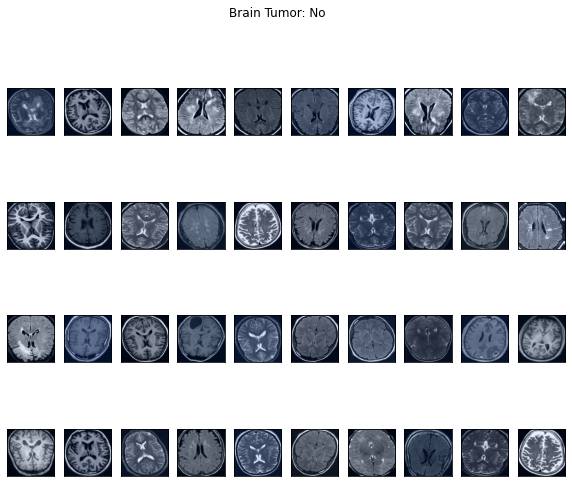

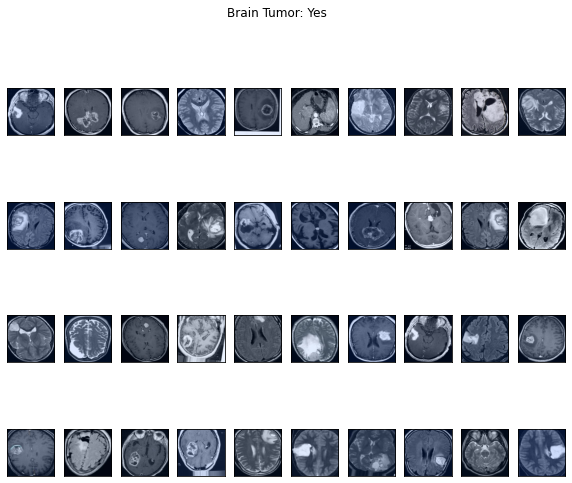

In [12]:
sample_images(X, y)

##Splitting the data into training, testing and validation sets

In [13]:
def data_split(X, y, test_size=0.3): 
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = data_split(X, y, test_size=0.2)

In [15]:
def data_percentage(y):
    
    Total=len(y)
    class_1 = np.sum(y)
    class_0 = Total - class_1
    
    pos_prec = (class_1* 100.0)/ Total
    neg_prec = (class_0* 100.0)/ Total
    
    print(f"Number of examples: {Total}")
    print(f"number of pos examples: {class_1}") 
    print(f"number of neg examples: {class_0}")

In [16]:
data_percentage(y)
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Number of examples: 1965
number of pos examples: 1084
number of neg examples: 881
Training Data:
Number of examples: 1572
number of pos examples: 861
number of neg examples: 711
Validation Data:
Number of examples: 197
number of pos examples: 115
number of neg examples: 82
Testing Data:
Number of examples: 196
number of pos examples: 108
number of neg examples: 88


##Building CNN model

In [17]:
vgg16_weight_path = '/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
image_size = (240,240)
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=image_size + (3,)
)

In [18]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


##Running the model and calculating accuracy and loss

In [19]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
50/50 [==============================] - 42s 445ms/step - loss: 0.5253 - accuracy: 0.7252 - val_loss: 0.3470 - val_accuracy: 0.8934
Epoch 2/25
50/50 [==============================] - 17s 339ms/step - loss: 0.2886 - accuracy: 0.8772 - val_loss: 0.3081 - val_accuracy: 0.8731
Epoch 3/25
50/50 [==============================] - 17s 338ms/step - loss: 0.2258 - accuracy: 0.9084 - val_loss: 0.2279 - val_accuracy: 0.9340
Epoch 4/25
50/50 [==============================] - 17s 337ms/step - loss: 0.1659 - accuracy: 0.9497 - val_loss: 0.2108 - val_accuracy: 0.9289
Epoch 5/25
50/50 [==============================] - 17s 338ms/step - loss: 0.1301 - accuracy: 0.9644 - val_loss: 0.1715 - val_accuracy: 0.9492
Epoch 6/25
50/50 [==============================] - 17s 338ms/step - loss: 0.1114 - accuracy: 0.9733 - val_loss: 0.1581 - val_accuracy: 0.9594
Epoch 7/25
50/50 [==============================] - 17s 338ms/step - loss: 0.0936 - accuracy: 0.9816 - val_loss: 0.1435 - val_accuracy: 0.9543

In [20]:
history = model.history.history

In [21]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    plt.figure()

    # Loss
    

    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
   
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
 
    plt.show()

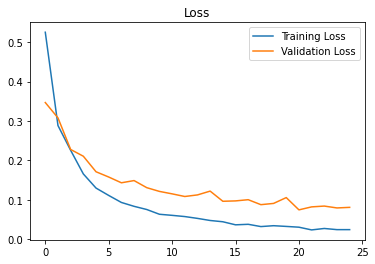

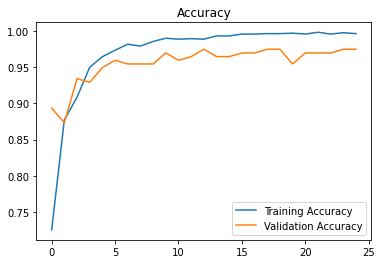

In [22]:
plot_metrics(history)

In [23]:
model.metrics_names

['loss', 'accuracy']

In [24]:
loss, acc = model.evaluate(x=X_val, y=y_val)

7/7 [==============================] - 2s 272ms/step - loss: 0.0812 - accuracy: 0.9746





##Calculating Metrics for the model

In [25]:
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx = confusion_matrix(y_train, predictions) 
print(confusion_mtx)

total=sum(sum(confusion_mtx))

accuracy=(confusion_mtx[0,0]+confusion_mtx[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[0,1])
print('Sensitivity : ', sensitivity )

specificity = confusion_mtx[1,1]/(confusion_mtx[1,0]+confusion_mtx[1,1])
print('Specificity : ', specificity)

Precision = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[1,0])
print('Precision : ', Precision)

f1_score = (2*sensitivity*Precision)/(Precision+sensitivity)
print('F1_score : ',f1_score)

[[711   0]
 [  0 861]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision :  1.0
F1_score :  1.0


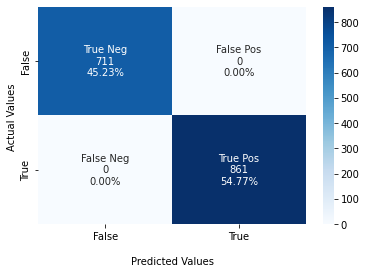

In [26]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mtx.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mtx.flatten()/np.sum(confusion_mtx)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(confusion_mtx, annot=labels, fmt='', cmap='Blues')


ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [27]:

predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]


confusion_mtx_test = confusion_matrix(y_test, predictions) 
print(confusion_mtx_test)

total=sum(sum(confusion_mtx_test))

accuracy=(confusion_mtx_test[0,0]+confusion_mtx_test[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = confusion_mtx_test[0,0]/(confusion_mtx_test[0,0]+confusion_mtx_test[0,1])
print('Sensitivity : ', sensitivity )

specificity = confusion_mtx_test[1,1]/(confusion_mtx_test[1,0]+confusion_mtx_test[1,1])
print('Specificity : ', specificity)

Precision = confusion_mtx_test[0,0]/(confusion_mtx_test[0,0]+confusion_mtx_test[1,0])
print('Precision : ', Precision)

f1_score = (2*sensitivity*Precision)/(Precision+sensitivity)
print('F1_score : ',f1_score)


[[ 87   1]
 [  4 104]]
Accuracy :  0.9744897959183674
Sensitivity :  0.9886363636363636
Specificity :  0.9629629629629629
Precision :  0.9560439560439561
F1_score :  0.9720670391061453


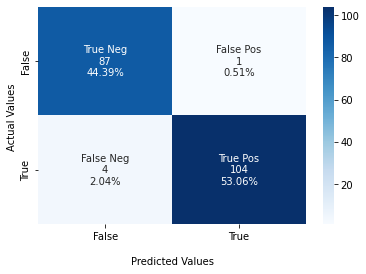

In [28]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mtx_test.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mtx_test.flatten()/np.sum(confusion_mtx_test)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(confusion_mtx_test, annot=labels, fmt='', cmap='Blues')


ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [29]:
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx_val = confusion_matrix(y_val, predictions) 
print(confusion_mtx_val)

total=sum(sum(confusion_mtx_val))

accuracy=(confusion_mtx_val[0,0]+confusion_mtx_val[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = confusion_mtx_val[0,0]/(confusion_mtx_val[0,0]+confusion_mtx_val[0,1])
print('Sensitivity : ', sensitivity )

specificity = confusion_mtx_val[1,1]/(confusion_mtx_val[1,0]+confusion_mtx_val[1,1])
print('Specificity : ', specificity)

Precision = confusion_mtx_val[0,0]/(confusion_mtx_val[0,0]+confusion_mtx_val[1,0])
print('Precision : ', Precision)

f1_score = (2*sensitivity*Precision)/(Precision+sensitivity)
print('F1_score : ',f1_score)

[[ 80   2]
 [  3 112]]
Accuracy :  0.9746192893401016
Sensitivity :  0.975609756097561
Specificity :  0.9739130434782609
Precision :  0.963855421686747
F1_score :  0.9696969696969697


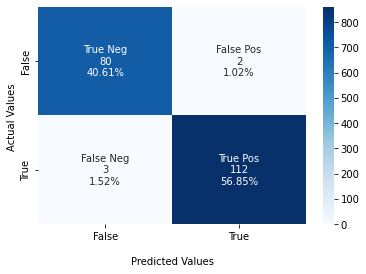

In [30]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mtx_val.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mtx_val.flatten()/np.sum(confusion_mtx_val)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(confusion_mtx, annot=labels, fmt='', cmap='Blues')


ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()